## 成交量与未平仓量


In [1]:
from datetime import datetime, timedelta

startTime = datetime(2022,11,12)
endTime = datetime(2023,1,31, 23, 59)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import talib as ta

In [4]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [5]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [6]:
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [7]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName]
            }

In [8]:
def resampleDf(data, freq='H'):
#     df = data.drop('_id', axis=1)
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

def resampleOiDf(data, freq='H'):
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'oi':'last'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [9]:
def addSymbol(dataDf, symbolName):  
    dataDf['symbol'] = symbolName
    return dataDf

In [10]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [11]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [12]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [13]:
multiDf

open      high       low     close  \
datetime            symbol                                           
2022-11-12 00:00:00 btc     16900.78  16934.50  16543.95  16836.28   
                    eth      1262.54   1264.00   1233.24   1250.21   
2022-11-12 01:00:00 btc     16836.28  16963.71  16750.10  16909.31   
                    eth      1250.21   1278.87   1246.88   1274.30   
2022-11-12 02:00:00 btc     16909.31  17045.09  16802.07  16837.11   
...                              ...       ...       ...       ...   
2023-01-31 21:00:00 eth      1573.67   1588.73   1572.89   1588.14   
2023-01-31 22:00:00 btc     23126.94  23197.38  23056.00  23119.64   
                    eth      1588.13   1589.56   1579.77   1583.09   
2023-01-31 23:00:00 btc     23118.76  23206.84  23075.01  23114.27   
                    eth      1583.09   1596.13   1581.92   1588.32   

                                 volume  
datetime            symbol               
2022-11-12 00:00:00 btc     17333.46290  
                    eth     60945.74360  
2022-11-12 01:00:00 btc     13359.05393  
                    eth     49711.20880  
2022-11-12 02:00:00 btc     12471.61035  
...                                 ...  
2023-01-31 21:00:00 eth     32104.34380  
2023-01-31 22:00:00 btc     19857.46975  
                    eth     17105.19810  
2023-01-31 23:00:00 btc     14733.07390  
                    eth     17445.17410  

[3888 rows x 5 columns]

In [14]:
btcOi = pd.read_csv('btcOi.csv')
ethOi = pd.read_csv('ethOi.csv')

In [15]:
btcOi.tail()

,Unnamed: 0,timestamp,oi,notional,datetime
17275,17275,1670065500,129771.135,2.199595e+09,2022-12-03 19:05:00
17276,17276,1670065200,129735.207,2.199707e+09,2022-12-03 19:00:00
17277,17277,1670064900,129720.446,2.199579e+09,2022-12-03 18:55:00
17278,17278,1670064600,129728.198,2.199180e+09,2022-12-03 18:50:00
17279,17279,1670064300,129672.042,2.197431e+09,2022-12-03 18:45:00


In [16]:
btcOiDf = btcOi[['oi', 'notional', 'datetime']]
ethOiDf = ethOi[['oi', 'notional', 'datetime']]

In [17]:
btcOiDf['datetime'] = list(map(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S"), btcOiDf['datetime']))
ethOiDf['datetime'] = list(map(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S"), ethOiDf['datetime']))

In [18]:
btcOi = setIndex(addSymbol(resampleOiDf(btcOiDf), 'btc'))
ethOi = setIndex(addSymbol(resampleOiDf(ethOiDf), 'eth'))

In [19]:
oiDf = pd.concat([btcOi, ethOi]).sort_index()

In [20]:
oiVolumeDf = pd.concat([multiDf, oiDf], axis=1).dropna()

In [21]:
oiVolumeDf

open      high       low     close  \
datetime            symbol                                           
2022-12-03 18:00:00 btc     16979.13  16984.50  16951.47  16963.51   
                    eth      1273.55   1273.55   1269.58   1271.33   
2022-12-03 19:00:00 btc     16963.51  16965.66  16880.88  16943.43   
                    eth      1271.33   1271.33   1260.54   1269.39   
2022-12-03 20:00:00 btc     16943.43  16968.99  16930.42  16965.71   
...                              ...       ...       ...       ...   
2023-01-31 21:00:00 eth      1573.67   1588.73   1572.89   1588.14   
2023-01-31 22:00:00 btc     23126.94  23197.38  23056.00  23119.64   
                    eth      1588.13   1589.56   1579.77   1583.09   
2023-01-31 23:00:00 btc     23118.76  23206.84  23075.01  23114.27   
                    eth      1583.09   1596.13   1581.92   1588.32   

                                 volume           oi  
datetime            symbol                            
2022-12-03 18:00:00 btc      4956.11650   129720.446  
                    eth      6365.87220  1503942.764  
2022-12-03 19:00:00 btc      9684.26894   129429.417  
                    eth     16374.21960  1495373.362  
2022-12-03 20:00:00 btc      6461.23071   129868.580  
...                                 ...          ...  
2023-01-31 21:00:00 eth     32104.34380   992941.132  
2023-01-31 22:00:00 btc     19857.46975    99640.982  
                    eth     17105.19810   999166.504  
2023-01-31 23:00:00 btc     14733.07390   100021.193  
                    eth     17445.17410   997785.981  

[2844 rows x 6 columns]

In [22]:
btcOiVolumeDf = oiVolumeDf.loc[:,pd.IndexSlice['btc'],:]
ethOiVolumeDf = oiVolumeDf.loc[:,pd.IndexSlice['eth'],:]

In [23]:
shortPeriod = 168
longPeriod = shortPeriod*4

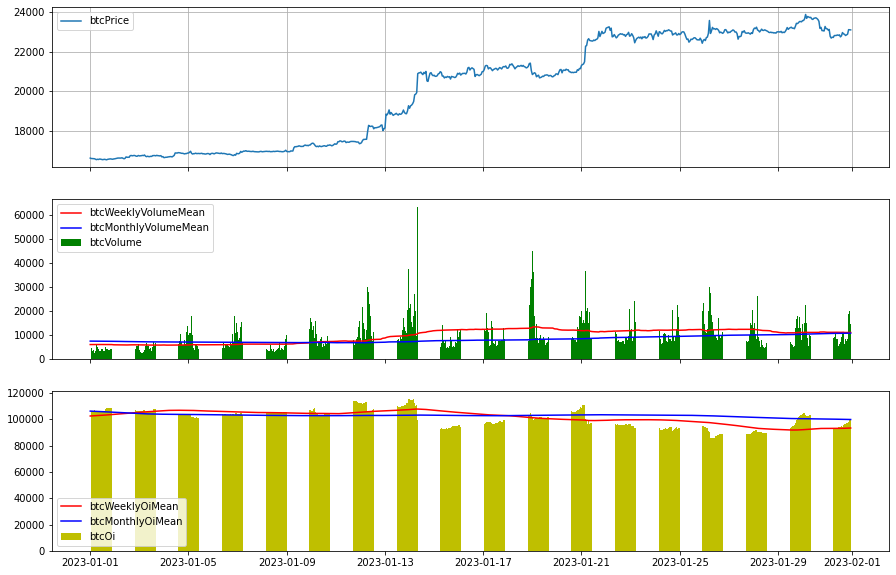

In [24]:
lastMonth = 31*24
figBtc, (axBtc, ax1Btc, ax2Btc) = plt.subplots(3,1,sharex=True, figsize=(15,10))
# figBtc.subplots_adjust(bottom=0.5)
axBtc.grid(True)
axBtc.plot(btcOiVolumeDf.iloc[-lastMonth:].close, label='btcPrice')
axBtc.legend()
ax1Btc.bar(btcOiVolumeDf.iloc[-lastMonth:].index, btcOiVolumeDf.iloc[-lastMonth:].volume, color='g', width=0.02, label='btcVolume')
ax1Btc.plot(ta.MA(btcOiVolumeDf.volume, shortPeriod).iloc[-lastMonth:], color='r', label='btcWeeklyVolumeMean')
ax1Btc.plot(ta.MA(btcOiVolumeDf.volume, longPeriod).iloc[-lastMonth:], color='b', label='btcMonthlyVolumeMean')
ax1Btc.legend(loc='upper left')
ax2Btc.bar(btcOiVolumeDf.iloc[-lastMonth:].index, btcOiVolumeDf.oi.iloc[-lastMonth:], color='y', width=0.02, label='btcOi')
ax2Btc.plot(ta.MA(btcOiVolumeDf.oi, shortPeriod).iloc[-lastMonth:], color='r', label='btcWeeklyOiMean')
ax2Btc.plot(ta.MA(btcOiVolumeDf.oi, longPeriod).iloc[-lastMonth:], color='b', label='btcMonthlyOiMean')
ax2Btc.legend()
figBtc.savefig('oiVolumePriceBtc')

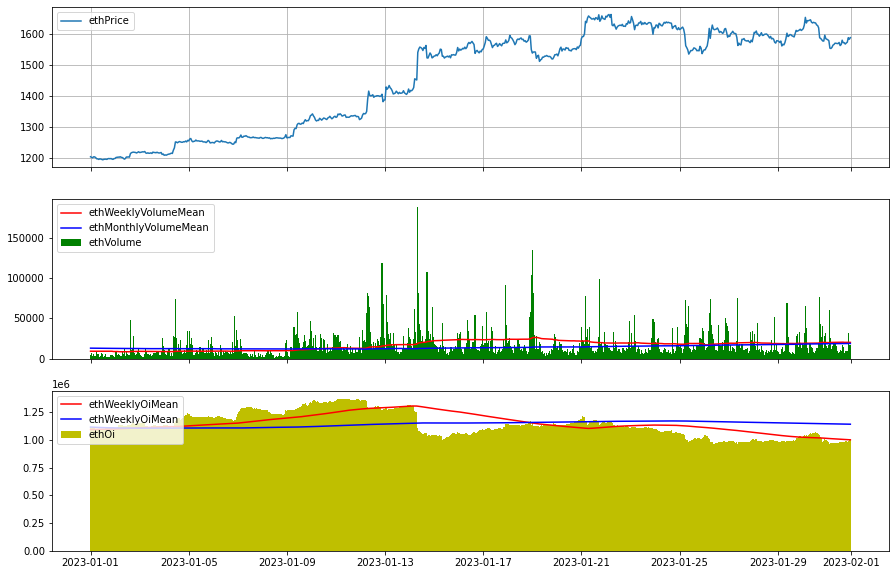

In [25]:
lastMonth = 31*24
figEth, (axEth,ax1Eth, ax2Eth) = plt.subplots(3,1,sharex=True, figsize=(15,10))
# figEth.subplots_adjust(bottom=0.5)
axEth.grid(True)
axEth.plot(ethOiVolumeDf.iloc[-lastMonth:].close, label='ethPrice')
axEth.legend(loc='upper left')
ax1Eth.bar(ethOiVolumeDf.iloc[-lastMonth:].index, ethOiVolumeDf.iloc[-lastMonth:].volume, color='g', width=0.045, label='ethVolume')
ax1Eth.plot(ta.MA(ethOiVolumeDf.volume, shortPeriod).iloc[-lastMonth:], color='r', label='ethWeeklyVolumeMean')
ax1Eth.plot(ta.MA(ethOiVolumeDf.volume, longPeriod).iloc[-lastMonth:], color='b', label='ethMonthlyVolumeMean')
ax1Eth.legend(loc='upper left')
ax2Eth.bar(ethOiVolumeDf.iloc[-lastMonth:].index, ethOiVolumeDf.oi.iloc[-lastMonth:], color='y', width=0.045, label='ethOi')
ax2Eth.plot(ta.MA(ethOiVolumeDf.oi, shortPeriod).iloc[-lastMonth:], color='r', label='ethWeeklyOiMean')
ax2Eth.plot(ta.MA(ethOiVolumeDf.oi, longPeriod).iloc[-lastMonth:], color='b', label='ethWeeklyOiMean')
ax2Eth.legend(loc='upper left')
figEth.savefig('oiVolumePriceEth')

In [26]:
close = oiVolumeDf.close.unstack()
volume = oiVolumeDf.volume.unstack()
oi = oiVolumeDf.oi.unstack()

In [27]:
oi

symbol,btc,eth
datetime,,
2022-12-03 18:00:00,129720.446,1503942.764
2022-12-03 19:00:00,129429.417,1495373.362
2022-12-03 20:00:00,129868.580,1484744.873
2022-12-03 21:00:00,130305.894,1479420.987
2022-12-03 22:00:00,130300.553,1469283.662
...,...,...
2023-01-31 19:00:00,97022.316,985660.888
2023-01-31 20:00:00,97457.766,984310.435
2023-01-31 21:00:00,98378.574,992941.132


In [28]:
closeMaRatio = close.rolling(shortPeriod).mean()/close.rolling(longPeriod).mean()
volumeMaRatio = volume.rolling(shortPeriod).mean()/volume.rolling(longPeriod).mean()
oiMaRatio = oi.rolling(shortPeriod).mean()/oi.rolling(longPeriod).mean()

In [29]:
def cal_pctChange(data, lastDay, periodList=[7]):
    pctChangeDict = {}
    for period in periodList:
        pctChangeDict[str(period)+'Day'] = round((data.loc[lastDay]/data.loc[lastDay-timedelta(hours=period*24)]-1)*100, 2)
    pctChangeDf = pd.Series(pctChangeDict)
    return pctChangeDf

In [30]:
endTime = oiMaRatio.index[-1]
maChangeDf = pd.DataFrame({
    'btcCloseRatioPctChange': cal_pctChange(closeMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethCloseRatioPctChange': cal_pctChange(closeMaRatio.eth, endTime, [1, 3, 5, 8, 13]),
    'btcVolumeRatioPctChange': cal_pctChange(volumeMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethVolumeRatioPctChange': cal_pctChange(volumeMaRatio.eth, endTime, [1, 3, 5, 8, 13]),   
    'btcOpenInterestRatioPctChange': cal_pctChange(oiMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethOpenInterestRatioPctChange': cal_pctChange(oiMaRatio.eth, endTime, [1, 3, 5, 8, 13]),
})

In [31]:
maChangeDfT = round(maChangeDf.T, 2)

In [32]:
maChangeDfT['avg'] = maChangeDfT.mean(axis=1)

In [33]:
maChangeDfT

,1Day,3Day,5Day,8Day,13Day,avg
btcCloseRatioPctChange,-1.13,-2.86,-3.61,-3.59,-1.24,-2.486
ethCloseRatioPctChange,-1.37,-3.79,-5.77,-7.62,-7.21,-5.152
btcVolumeRatioPctChange,-2.69,-7.36,-18.09,-20.58,-36.41,-17.026
ethVolumeRatioPctChange,-0.55,0.14,-4.75,-10.96,-39.13,-11.050
btcOpenInterestRatioPctChange,0.72,2.23,-0.43,-3.10,-4.89,-1.094
ethOpenInterestRatioPctChange,-0.88,-3.08,-6.69,-9.48,-12.06,-6.438


In [34]:
maChangeDfT.to_excel('RatioPctChange.xlsx')

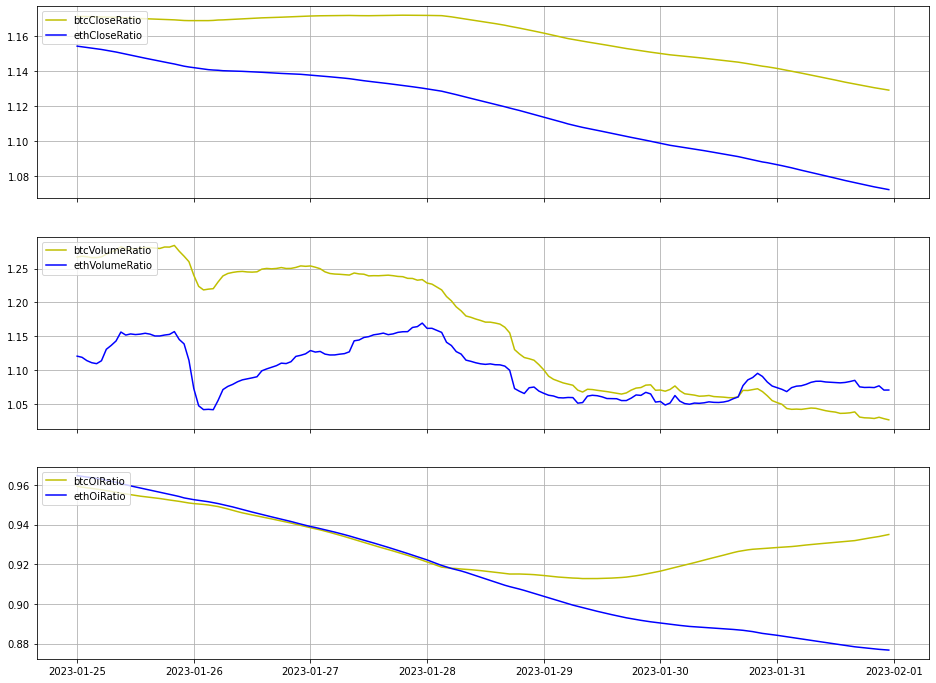

In [35]:
f2Coin, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,12))
ax1.plot(closeMaRatio.btc.iloc[-24*7:], 'y', label='btcCloseRatio')
ax1.plot(closeMaRatio.eth.iloc[-24*7:], 'b', label='ethCloseRatio')
ax1.legend(loc='upper left')
ax1.grid()
ax2.plot(volumeMaRatio.btc.iloc[-24*7:], 'y', label='btcVolumeRatio')
ax2.plot(volumeMaRatio.eth.iloc[-24*7:], 'b', label='ethVolumeRatio')
ax2.legend(loc='upper left')
ax2.grid()
ax3.plot(oiMaRatio.btc.iloc[-24*7:], 'y', label='btcOiRatio')
ax3.plot(oiMaRatio.eth.iloc[-24*7:], 'b', label='ethOiRatio')
ax3.legend(loc='upper left')
ax3.grid()
f2Coin.savefig('RatioChart')